#Import Libraries

In [137]:
import pandas as pd
import os
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

#Load Data

Source: https://data.gov.sg/datasets?topics=housing&page=1&resultId=189

In [139]:
# List all files in the Colab directory
uploaded_files = os.listdir('/content/')
print("Files in Colab:", uploaded_files)

Files in Colab: ['.config', 'Resale flat prices based on registration date from Jan-2017 onwards.csv', 'Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv', 'Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv', 'Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv', 'Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv', 'sample_data']


In [140]:
# Load each CSV file individually
file1 = pd.read_csv('/content/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv')
file2 = pd.read_csv('/content/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv')
file3 = pd.read_csv('/content/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv')
file4 = pd.read_csv('/content/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv')
file5 = pd.read_csv('/content/Resale flat prices based on registration date from Jan-2017 onwards.csv')


In [141]:
# Print column names of each CSV
print("Columns in file1:", file1.columns)
print("Columns in file2:", file2.columns)
print("Columns in file3:", file3.columns)
print("Columns in file4:", file4.columns)
print("Columns in file5:", file5.columns)

Columns in file1: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file2: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file3: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Columns in file4: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')
Columns in file5: Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale

file4 and file5 contain an extra column "remaining_lease"

In [142]:
# Add missing 'remaining_lease' column to file1, file2, and file3
for df in [file1, file2, file3]:
    df['remaining_lease'] = np.nan  # Assign NaN to missing column

In [143]:
# Concatenate all files
df = pd.concat([file1, file2, file3, file4, file5], ignore_index=True)

# Display dataset info to confirm
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947852 entries, 0 to 947851
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                947852 non-null  object 
 1   town                 947852 non-null  object 
 2   flat_type            947852 non-null  object 
 3   block                947852 non-null  object 
 4   street_name          947852 non-null  object 
 5   storey_range         947852 non-null  object 
 6   floor_area_sqm       947852 non-null  float64
 7   flat_model           947852 non-null  object 
 8   lease_commence_date  947852 non-null  int64  
 9   resale_price         947852 non-null  float64
 10  remaining_lease      238802 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 79.5+ MB
None


In [144]:
# Check data
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN


#Feature Engineering



## Time-Based Features
Convert transaction dates into year, month and quarter for trend detection



In [145]:
# Convert month to datetime format
df['month'] = pd.to_datetime(df['month'])

# Extract year, month, and quarter
df['year'] = df['month'].dt.year
df['month_num'] = df['month'].dt.month
df['quarter'] = df['month'].dt.quarter
df['year_month'] = df['month'].dt.to_period('M').astype(str)

# Drop the original month column (since we now have extracted features)
df.drop(columns=['month'], inplace=True)

print("✅ Time-based features added!")
display(df[['year', 'month_num', 'quarter', 'year_month']])


✅ Time-based features added!


,year,month_num,quarter,year_month
0,1990,1,1,1990-01
1,1990,1,1,1990-01
2,1990,1,1,1990-01
3,1990,1,1,1990-01
4,1990,1,1,1990-01
...,...,...,...,...
947847,2025,3,1,2025-03
947848,2025,3,1,2025-03
947849,2025,3,1,2025-03
947850,2025,3,1,2025-03


In [146]:
df[['year', 'month_num', 'quarter', 'year_month']].sample(20)  # Show 20 random rows

,year,month_num,quarter,year_month
851719,2021,8,3,2021-08
177128,1997,12,4,1997-12
100463,1995,9,3,1995-09
400223,2003,2,1,2003-02
930180,2024,7,3,2024-07
577424,2009,6,2,2009-06
659163,2012,3,1,2012-03
212531,1998,9,3,1998-09
244122,1999,3,1,1999-03
56851,1993,12,4,1993-12


##Location-Based Features
Encode town, street name using Label Encoding

In [147]:
print("Number of unique streets:", df['street_name'].nunique())
print("Top 10 most common streets:\n", df['street_name'].value_counts().head(10))

Number of unique streets: 589
Top 10 most common streets:
 street_name
YISHUN RING RD        17866
BEDOK RESERVOIR RD    14917
ANG MO KIO AVE 10     14006
ANG MO KIO AVE 3      12314
HOUGANG AVE 8          9495
TAMPINES ST 21         8391
BEDOK NTH ST 3         7660
BEDOK NTH RD           7560
ANG MO KIO AVE 4       7331
MARSILING DR           6748
Name: count, dtype: int64


Machine learning requires numerical data instead of text hence we use Label Encoding to replace each unique category with an integer

In [148]:
# Label Encoding for town and street_name
le_town = LabelEncoder()
le_street = LabelEncoder()

df['town'] = le_town.fit_transform(df['town'])
df['street_name'] = le_street.fit_transform(df['street_name'])

# Save mappings for later use
town_mapping = dict(zip(le_town.classes_, le_town.transform(le_town.classes_)))
street_mapping = dict(zip(le_street.classes_, le_street.transform(le_street.classes_)))

In [149]:
# Show full columns for town and street_name
display(df[['town', 'street_name']])


,town,street_name
0,0,14
1,0,14
2,0,14
3,0,14
4,0,14
...,...,...
947847,26,577
947848,26,578
947849,26,561
947850,26,573


In [150]:
df[['town', 'street_name']].sample(20)  # Show 20 random rows


,town,street_name
746268,1,43
51630,1,50
903335,13,285
722992,13,272
26229,19,100
138521,4,53
579035,25,529
444016,23,480
443521,14,519
719391,1,39


##Flat Characteristics
Include floor area, flat type, storey range as numerical inputs

In [151]:
# Label Encoding for categorical flat details
le_flat_type = LabelEncoder()
le_storey_range = LabelEncoder()
le_flat_model = LabelEncoder()

df['flat_type'] = le_flat_type.fit_transform(df['flat_type'])
df['storey_range'] = le_storey_range.fit_transform(df['storey_range'])
df['flat_model'] = le_flat_model.fit_transform(df['flat_model'])

In [152]:
# Check final dataset structure
print("✅ Flat characteristic features processed!")
display(df[['flat_type', 'storey_range', 'flat_model', 'floor_area_sqm']])

✅ Flat characteristic features processed!


,flat_type,storey_range,flat_model,floor_area_sqm
0,0,5,7,31.0
1,0,2,7,31.0
2,0,5,7,31.0
3,0,4,7,31.0
4,2,2,20,73.0
...,...,...,...,...
947847,3,0,21,91.0
947848,3,5,28,88.0
947849,4,5,9,122.0
947850,4,2,9,112.0


# LSTM Model

Train a regression model to predict resale prices.

## LSTM Training

In [153]:
# Define target variable (y)
y = df['resale_price']

# Define features (X) - Drop columns that are not useful for prediction
X = df.drop(columns=['resale_price', 'block'])  # Drop 'block' since it's too specific

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
monthly_avg = df.groupby('year_month')['resale_price'].mean().reset_index()
monthly_avg['year_month'] = pd.to_datetime(monthly_avg['year_month'])

In [156]:
# Scale resale prices
scaler = MinMaxScaler()
scaled = scaler.fit_transform(monthly_avg['resale_price'].values.reshape(-1, 1))

In [157]:
# Create sequences
def create_sequences(data, seq_len=12):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 10
X_seq, y_seq = create_sequences(scaled, seq_len)

In [158]:
# Split
split_index = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_index], X_seq[split_index:]
y_train, y_test = y_seq[:split_index], y_seq[split_index:]

In [159]:
# LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_len, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=8)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0598
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016
Epoch 16/50
42/42 ━━━━━━━━━━━━

## Evaluate Model

In [160]:
# Make predictions on test set
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM RMSE: {rmse:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
LSTM MAE: 23185.46
LSTM RMSE: 24884.33


MAE Value = Model's predictions are off by $Value

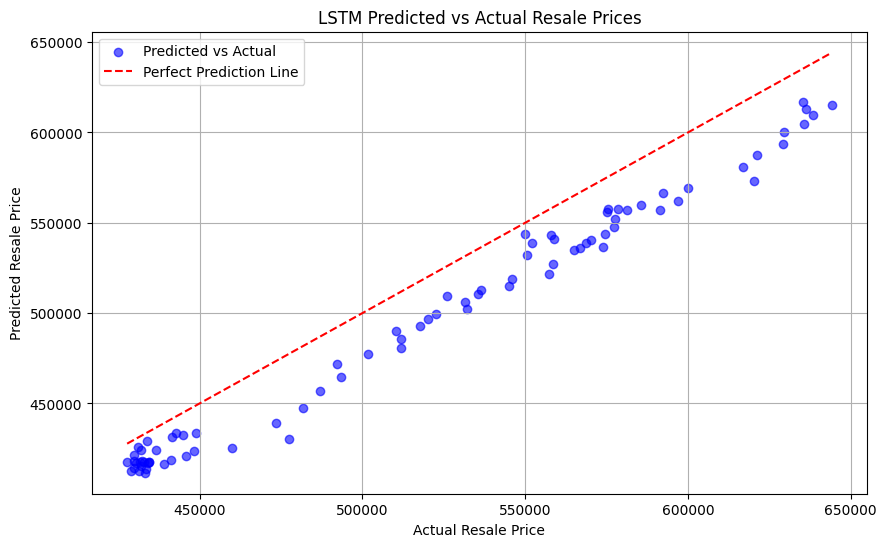

In [161]:
# Scatter plot: Actual vs Predicted (LSTM)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)],
         [min(y_test_rescaled), max(y_test_rescaled)],
         color='red', linestyle='--', label='Perfect Prediction Line')
plt.xlabel("Actual Resale Price")
plt.ylabel("Predicted Resale Price")
plt.title("LSTM Predicted vs Actual Resale Prices")
plt.legend()
plt.grid()
plt.show()

# Visualize Market Trends

##Monthly Trends

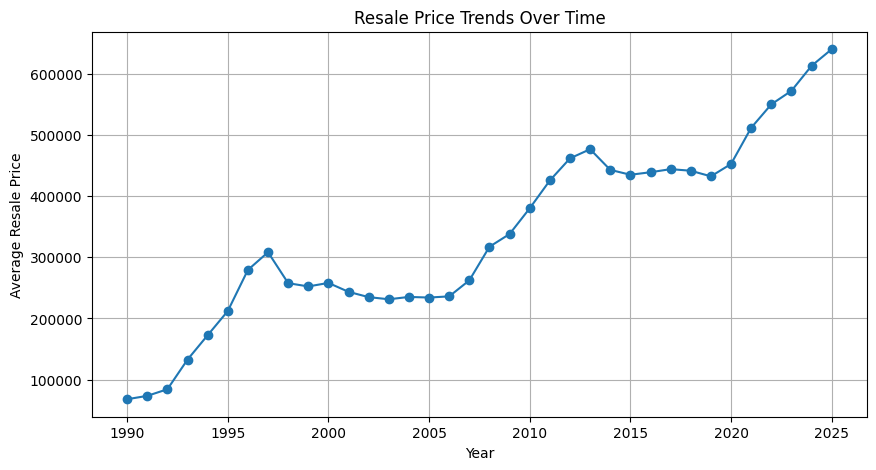

In [162]:
# Group data by year and calculate average resale price
yearly_trends = df.groupby('year')['resale_price'].mean()

plt.figure(figsize=(10, 5))
plt.plot(yearly_trends.index, yearly_trends.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Resale Price')
plt.title('Resale Price Trends Over Time')
plt.grid()
plt.show()


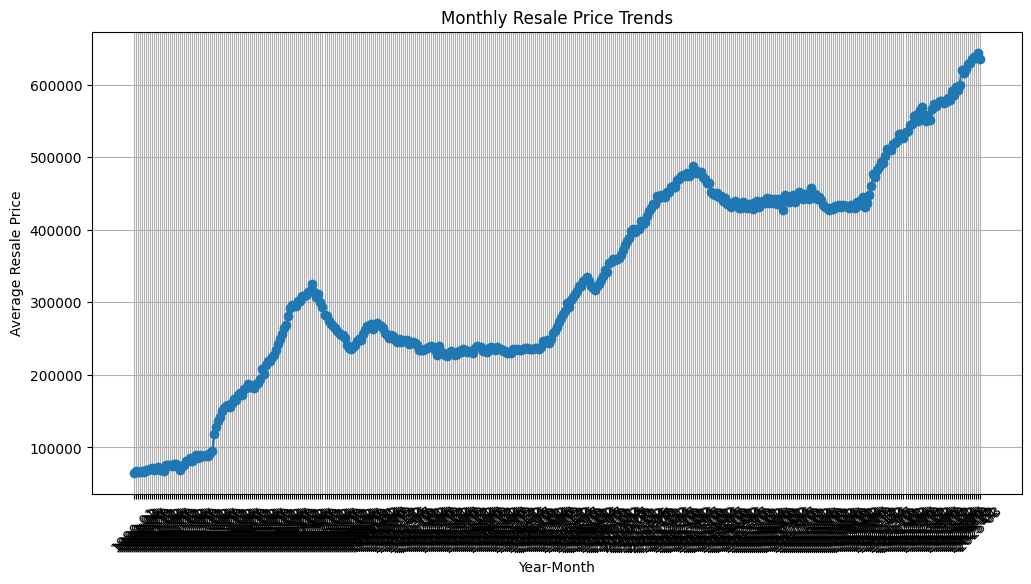

In [163]:
# Create a new column for year-month
df['year_month'] = df['year'].astype(str) + "-" + df['month_num'].astype(str).str.zfill(2)

# Group by year-month and get the average resale price
monthly_trends = df.groupby('year_month')['resale_price'].mean()

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends.index, monthly_trends.values, marker='o', linestyle='-')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xlabel('Year-Month')
plt.ylabel('Average Resale Price')
plt.title('Monthly Resale Price Trends')
plt.grid()
plt.show()


## Location-Based Analysis

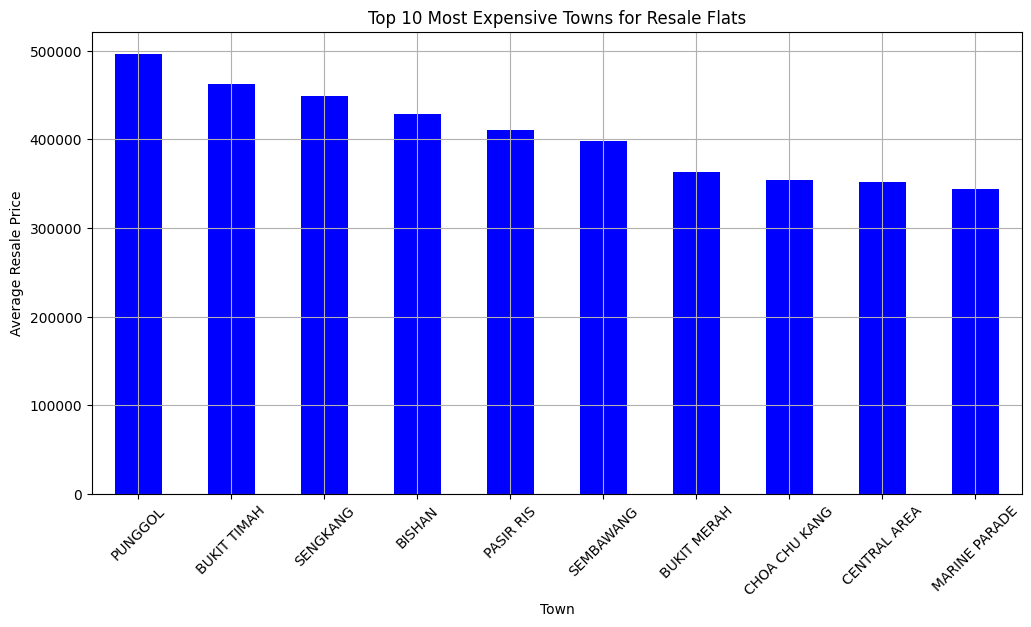

In [164]:
# Group data by town and calculate average resale price
town_trends = df.groupby('town')['resale_price'].mean().sort_values(ascending=False).head(10)

# Convert town numbers back to names
town_trends.index = town_trends.index.map(lambda x: le_town.inverse_transform([x])[0])

# Plot the corrected town names
plt.figure(figsize=(12, 6))
town_trends.plot(kind='bar', color='blue')
plt.xlabel("Town")
plt.ylabel("Average Resale Price")
plt.title("Top 10 Most Expensive Towns for Resale Flats")
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [165]:
# Create a 'decade' column
df['decade'] = (df['year'] // 10) * 10  # This converts 1995 → 1990, 2007 → 2000, etc.

# Check if it worked
df[['year', 'decade']].sample(10)

,year,decade
324434,2001,2000
263914,1999,1990
372038,2002,2000
740234,2016,2010
636816,2011,2010
347152,2001,2000
443891,2004,2000
175885,1997,1990
532046,2007,2000
256325,1999,1990


In [166]:
# Group by decade and town, then calculate the average resale price
decade_town_prices = df.groupby(['decade', 'town'])['resale_price'].mean().reset_index()

# Find the top 5 most expensive towns for each decade
top_towns_per_decade = decade_town_prices.sort_values(['decade', 'resale_price'], ascending=[True, False])

# Show only the top 5 towns per decade
top_towns_per_decade = top_towns_per_decade.groupby('decade').head(5)

# Convert town labels back to names
top_towns_per_decade['town'] = top_towns_per_decade['town'].map(lambda x: le_town.inverse_transform([x])[0])

# Round resale_price to whole numbers
top_towns_per_decade['resale_price'] = top_towns_per_decade['resale_price'].round(0).astype(int)

print(top_towns_per_decade)

    decade           town  resale_price
17    1990      PASIR RIS        373272
2     1990         BISHAN        344194
6     1990    BUKIT TIMAH        339514
8     1990  CHOA CHU KANG        302621
22    1990       TAMPINES        263429
32    2000    BUKIT TIMAH        360896
43    2000        PUNGGOL        348294
28    2000         BISHAN        340377
42    2000      PASIR RIS        336040
41    2000  MARINE PARADE        311503
58    2010    BUKIT TIMAH        655256
54    2010         BISHAN        581855
59    2010   CENTRAL AREA        554415
56    2010    BUKIT MERAH        532322
67    2010  MARINE PARADE        520753
84    2020    BUKIT TIMAH        782168
80    2020         BISHAN        720465
85    2020   CENTRAL AREA        700252
96    2020     QUEENSTOWN        654217
82    2020    BUKIT MERAH        653380


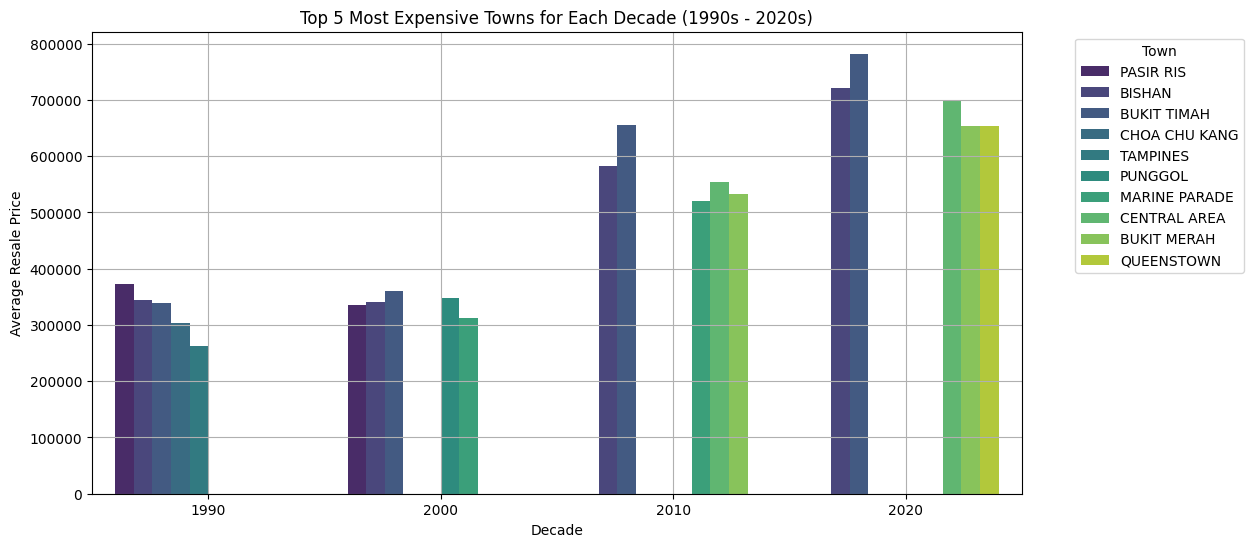

In [167]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=top_towns_per_decade,
    x='decade',
    y='resale_price',
    hue='town',
    palette='viridis'
)

plt.xlabel("Decade")
plt.ylabel("Average Resale Price")
plt.title("Top 5 Most Expensive Towns for Each Decade (1990s - 2020s)")
plt.legend(title="Town", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()